# Task 5: Learning Crowd Dynamics

In [158]:
# All imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math
import utils
from sklearn.decomposition import PCA
from scipy.interpolate import RBFInterpolator

%reload_ext autoreload
%autoreload 2

### TODO: Task 5.1 - Create a delay embedding with 350 delays of the first three measurement areas

In [3]:
data = np.loadtxt('../../data/MI_timesteps.txt')

In [4]:
data[1000:]

array([[1.0010e+03, 0.0000e+00, 2.0000e+00, ..., 5.0000e+00, 1.0000e+00,
        4.3000e+01],
       [1.0020e+03, 0.0000e+00, 2.0000e+00, ..., 5.0000e+00, 1.0000e+00,
        4.5000e+01],
       [1.0030e+03, 0.0000e+00, 2.0000e+00, ..., 5.0000e+00, 0.0000e+00,
        4.6000e+01],
       ...,
       [1.4999e+04, 0.0000e+00, 1.0000e+01, ..., 2.0000e+00, 1.0000e+00,
        4.0000e+01],
       [1.5000e+04, 0.0000e+00, 1.0000e+01, ..., 3.0000e+00, 1.0000e+00,
        4.1000e+01],
       [1.5001e+04, 0.0000e+00, 1.1000e+01, ..., 1.0000e+00, 0.0000e+00,
        4.2000e+01]])

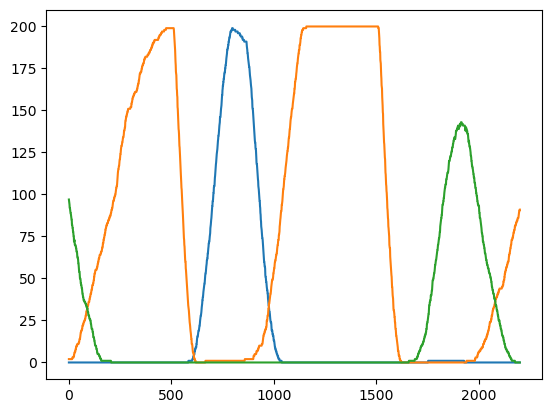

In [142]:
data_1 = data[1000:, 1:4]
#plt.plot(data_1[:,0],data_1[:,1])
#plt.plot(data_1[:,0],data_1[:,2])
#plt.plot(data_1[:,0],data_1[:,3])
plt.plot(data_1[:2200])

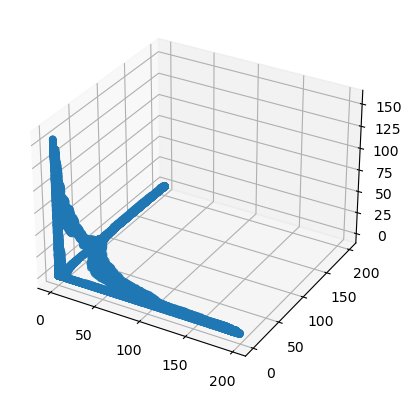

In [79]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(*data_1.T)
plt.show()

In [6]:
# Number of delays
num_delays = 350
num_areas = 3  # Columns per window
# Create windows
windows = utils.create_windows(data_1, num_delays, num_areas)

In [7]:
windows

array([[  0.,   2.,  97., ...,   0., 173.,   0.],
       [  0.,   2.,  96., ...,   0., 173.,   0.],
       [  0.,   2.,  95., ...,   0., 173.,   0.],
       ...,
       [  2.,   0.,   0., ...,   0.,  10.,  93.],
       [  2.,   0.,   0., ...,   0.,  10.,  93.],
       [  2.,   0.,   0., ...,   0.,  11.,  91.]])

In [8]:
windows_centered = utils.center_data(windows)

In [21]:
windows_centered.shape

(13651, 1053)

In [22]:
# TODO: Compute SVD
U, S, Vt = utils.compute_svd(windows_centered)

In [25]:
U.T

array([[ 5.71448178e-05, -2.21769988e-06, -6.15642034e-05, ...,
         1.01444864e-02,  1.01477352e-02,  1.01506279e-02],
       [-8.30989134e-03, -8.31634188e-03, -8.32218032e-03, ...,
         7.17420489e-04,  7.04669102e-04,  6.91127788e-04],
       [-4.79680238e-03, -4.75014215e-03, -4.70377141e-03, ...,
        -1.41025707e-02, -1.41393993e-02, -1.41754480e-02],
       ...,
       [ 5.13368788e-03, -1.36644980e-04, -3.40611612e-03, ...,
        -2.03738359e-02,  2.06344850e-02, -1.90398245e-02],
       [-1.40330560e-02,  1.57919559e-02, -1.44966137e-02, ...,
        -8.86240139e-03,  3.04301500e-03,  4.73383379e-03],
       [ 9.93093236e-03, -1.32004416e-03, -6.26580785e-03, ...,
        -1.35946814e-02,  1.70681120e-02, -1.76202582e-02]])

In [14]:
s = 0
for i in range(3):

    s+=utils.compute_energy(S,i+1)
s

82.85394584711489

The first 3 components account for almost 83% of the energy. We keep the first 3 components, as it is the dimensionality we need to embed our 1-d periodic manifold according to Takens

In [34]:
S_principal = S[:3]
# U 13651x1053  S x249  V_t 1053x1053
S_principal_matrix = np.zeros((U.shape[1], Vt.shape[0]))
np.fill_diagonal(S_principal_matrix, S_principal)
windows_reconstruct = U @ S_principal_matrix @ Vt

In [44]:
windows_reconstruct = windows_reconstruct + np.mean(windows, axis=0)

In [48]:
x_pca = U[:,0:3]
x_pca

array([[ 5.71448178e-05, -8.30989134e-03, -4.79680238e-03],
       [-2.21769988e-06, -8.31634188e-03, -4.75014215e-03],
       [-6.15642034e-05, -8.32218032e-03, -4.70377141e-03],
       ...,
       [ 1.01444864e-02,  7.17420489e-04, -1.41025707e-02],
       [ 1.01477352e-02,  7.04669102e-04, -1.41393993e-02],
       [ 1.01506279e-02,  6.91127788e-04, -1.41754480e-02]])

In [86]:
pca = PCA(n_components=3)  # Choose the number of components you want to keep
principal_components = pca.fit_transform(windows)

In [87]:
principal_components

array([[ 8.97581528e+00,  9.25937107e+02, -4.15524719e+02],
       [-3.48337177e-01,  9.26655864e+02, -4.11482760e+02],
       [-9.66997427e+00,  9.27306418e+02, -4.07465878e+02],
       ...,
       [ 1.59340846e+03, -7.99392225e+01, -1.22164022e+03],
       [ 1.59391876e+03, -7.85183877e+01, -1.22483051e+03],
       [ 1.59437312e+03, -7.70095346e+01, -1.22795324e+03]])

### TODO: Task 5.2 - Create 9 plots - one for each measurement area

In [88]:
x_original = data[1000:,1:]

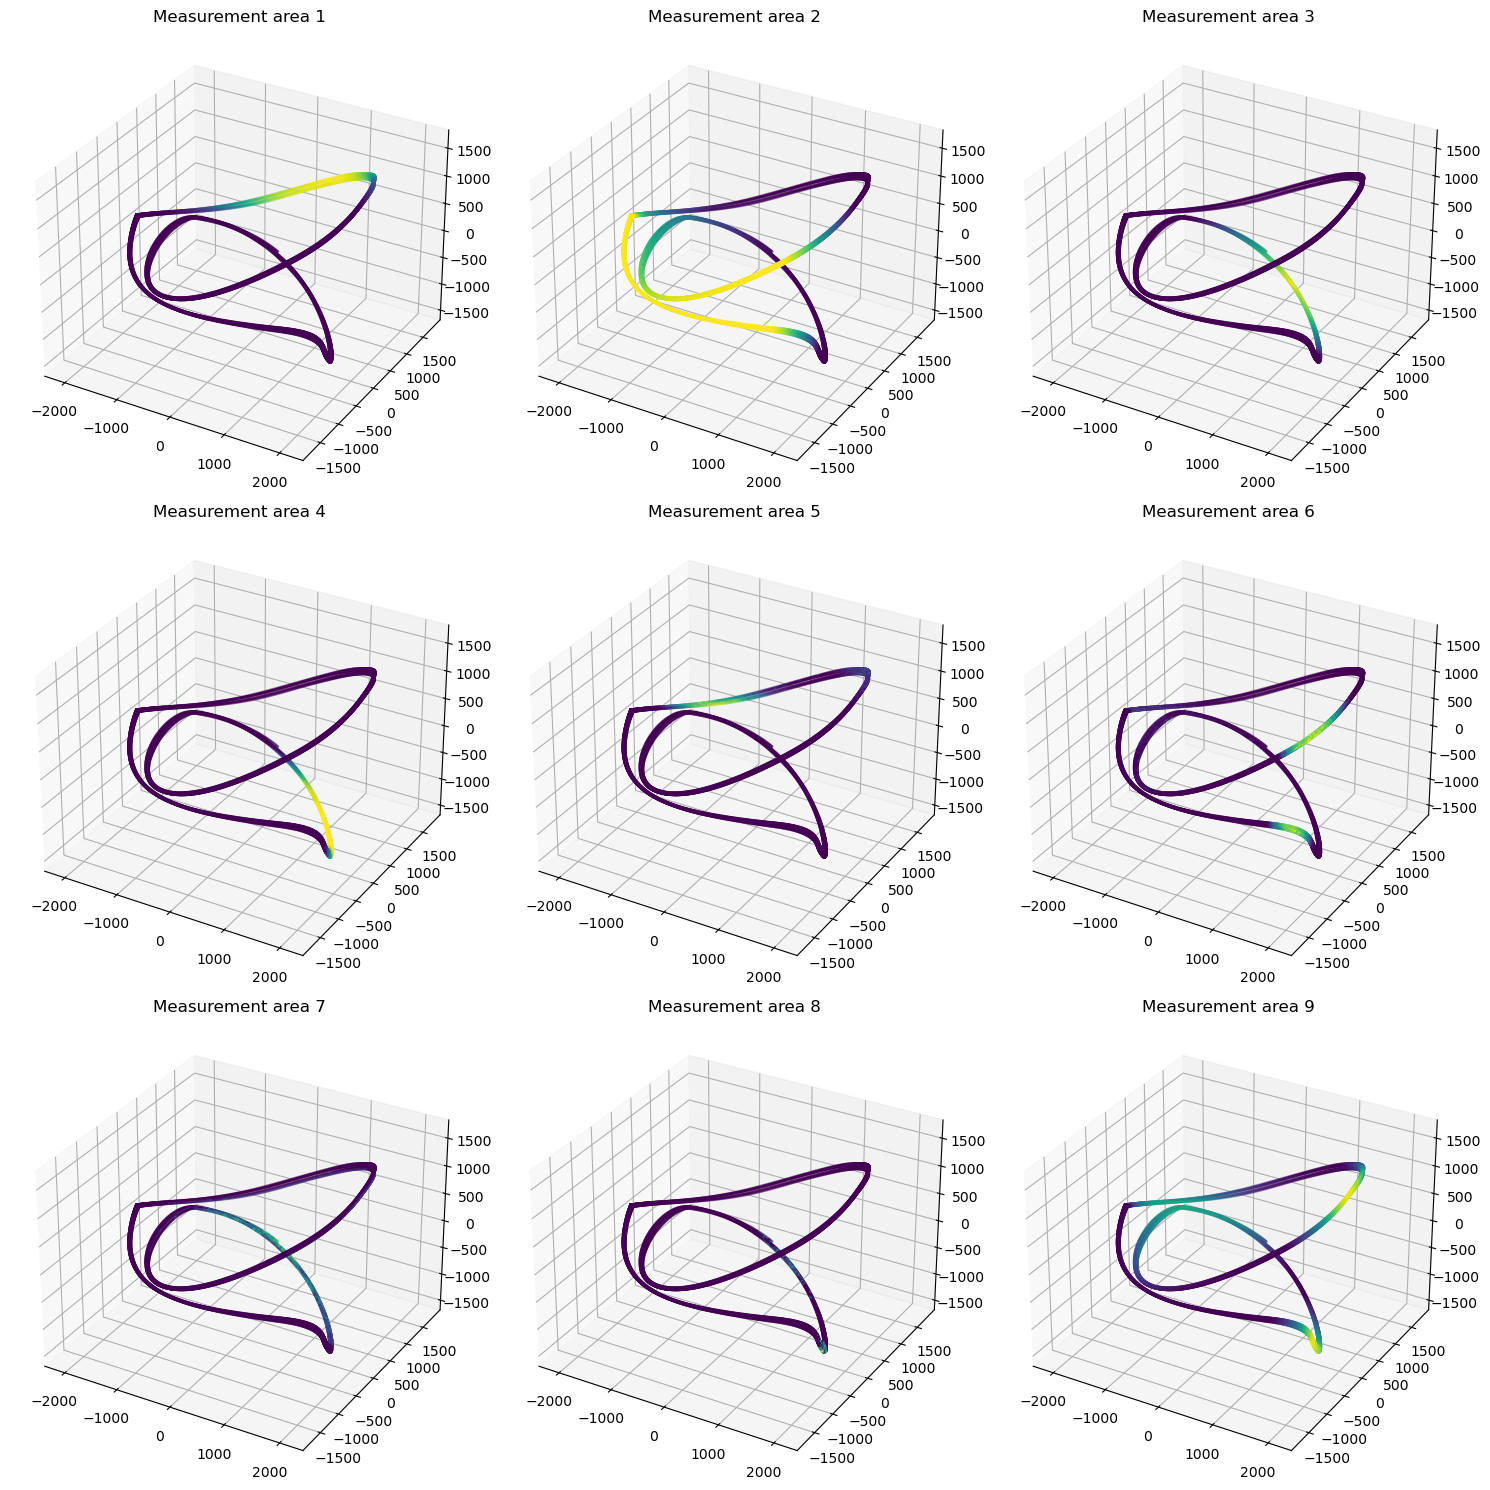

In [90]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15), subplot_kw={'projection': '3d'})
for i in range(9):
    row = i // 3  # Determine row index (0, 1, 2)
    col = i % 3   # Determine column index (0, 1, 2)
    ax = axs[row,col]
    ax.scatter(*principal_components.T, s=1, c=x_original[:len(x_pca), i])
    ax.set_title('Measurement area ' + str(i+1))
    #plt.show()

plt.tight_layout()
plt.show()

### TODO: Task 5.3 - Learn the dynamics on the periodic curve you embedded in the principal components.

In [91]:
# Compute arclengths
arclengths = np.zeros(len(principal_components))
for i in range(1, len(principal_components)):
    arclengths[i] = arclengths[i-1] + np.linalg.norm(principal_components[i] - principal_components[i-1])

In [93]:
# Compute change of arclength over time
change_of_arclength = np.diff(arclengths)

In [95]:
arclengths[:-1]

array([0.00000000e+00, 1.01879273e+01, 2.03590374e+01, ...,
       1.49443719e+05, 1.49447257e+05, 1.49450786e+05])

In [116]:
len(np.where(arclengths <= 25000))

1

In [117]:
np.where(arclengths <= 25000)

(array([   0,    1,    2, ..., 2289, 2290, 2291], dtype=int64),)

In [128]:
arclengths[:2143]

23204.221139911257

In [137]:
np.where(change_of_arclength<=0)

(array([7155, 7156, 7157, 7158], dtype=int64),)

In [138]:
change_of_arclength[7150:]

array([0.07797343, 0.07800539, 0.07803563, ..., 3.53767321, 3.52946793,
       3.49778881])

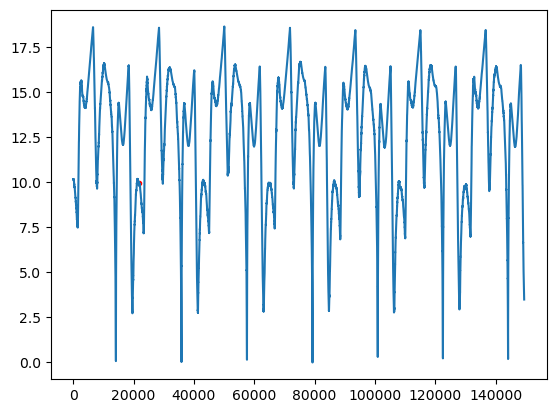

In [139]:
plt.plot(arclengths[:-1], change_of_arclength)
plt.scatter(arclengths[2000], change_of_arclength[2000],marker='.', color='r')
#plt.xlim(0,25000)

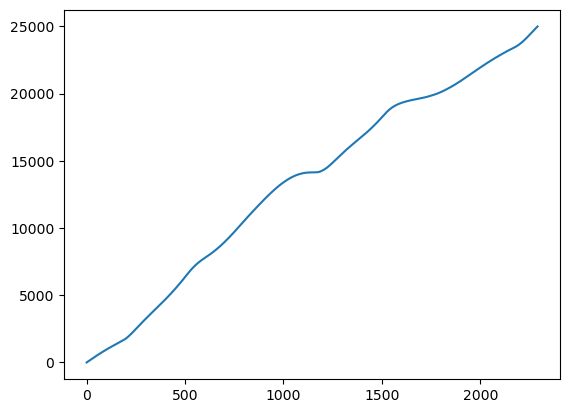

In [122]:
plt.plot(np.where(arclengths <= 25000)[0],arclengths[:len(np.where(arclengths <= 25000)[0])])
#plt.ylim(0,25000)

### TODO: Task 5.4 Prediction of utilization of the MI building 

In [180]:
# Hint : Use nonlin_func_approx from utils to compute utilization value by using radial basis function 
num_prediction = (len(data_1))
period = arclengths[2000]

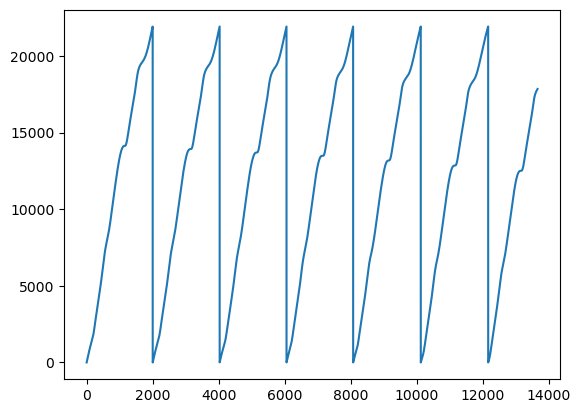

In [194]:
plt.plot(arclengths % period)

In [183]:
arclengths_period = arclengths % period

In [196]:
num_prediction

14001

In [164]:
MI_data = data_1[:,0:1]

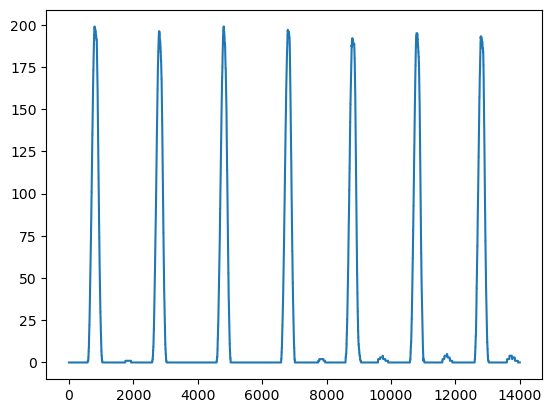

In [209]:
plt.plot(MI_data)

In [190]:
 change_of_arclength

array([10.1879273 , 10.17111006, 10.15455949, ...,  3.53767321,
        3.52946793,  3.49778881])

In [202]:
predicted_arclengths = np.zeros(len(arclengths))
predicted_arclengths[0] = arclengths_period[-1]

for i in range(1, len(arclengths)):
    print(i)
    predicted_arclengths[i] = predicted_arclengths[i-1] + change_of_arclength[i-1]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


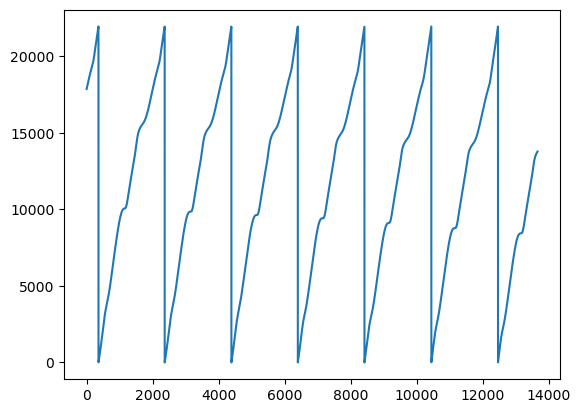

In [204]:
plt.plot(predicted_arclengths % period)

In [213]:
predicted_arclength_period =predicted_arclengths % period

In [214]:
predicted_arclengths = predicted_arclengths.reshape((len(predicted_arclengths),1))

In [215]:
arclengths = arclengths.reshape(len(arclengths),1)

In [223]:
predicted_MI = RBFInterpolator(arclengths[0:2000], MI_data[0:2000], kernel='gaussian', epsilon=0.08)(predicted_arclengths[0:2000])

utils.mean_squared_error(predicted_MI,MI_data[0:2000])

2843.3702559490284

In [224]:
predicted_MI

array([[6.12599395e-02],
       [1.58959631e-01],
       [2.95957421e-02],
       ...,
       [3.14020992e+01],
       [3.14020992e+01],
       [3.14020992e+01]])